# Define GNSS locations based on relative baselines and one absolute GNSS

arc1 taken as absolute and all other GNSS stations found relative to it

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from numpy import linalg as LA
from functools import reduce
import os
import sys
import time
import datetime 
import pandas as pd
import geopandas as gpd

from shapely.geometry import Point
import shapely
import fiona

Import the dataframe from 4

In [3]:
ldf = ['arc5arc4', 'arc1arc4', 'arc2arc1', 'arc2arc5', 'arc5arc6', 'arc1arc5', 'arc4arc6', 'arc1arc6']
ddf = {} #dictionary of dataframes

for df in ldf:
    ddf[df] =  pd.read_csv(f"/Volumes/arc_04/whitefar/DATA/TASMAN/GNSS_relative/DATAFRAME/dataframe_{df}_may1-18_2016.csv",header=0)

In [4]:
ddf['arc5arc4']

,YY,MM,DD,HR,MIN,Sec,dNorth,+-,dEast,+-.1,...,+-.3,Fract_DOY,index,Epoch,#BF,NotF,Rho_UA,Timestamp,unit1,unit2
0,2016,5,1,0,0,0,2075.3855,0.0219,494.2468,0.0169,...,64.12,122.000000,1,10,0,K,0.017,1.462018e+09,arc5,arc4
1,2016,5,1,0,0,30,2075.3694,0.0221,494.2466,0.0173,...,47.50,122.000347,2,10,0,S,0.009,1.462018e+09,arc5,arc4
2,2016,5,1,0,1,0,2075.3630,0.0065,494.2412,0.0043,...,47.50,122.000694,3,12,0,S,0.001,1.462018e+09,arc5,arc4
3,2016,5,1,0,1,30,2075.3712,0.0064,494.2368,0.0043,...,47.50,122.001042,4,12,0,S,0.001,1.462018e+09,arc5,arc4
4,2016,5,1,0,2,0,2075.3715,0.0064,494.2394,0.0043,...,47.50,122.001389,5,12,0,S,0.002,1.462018e+09,arc5,arc4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45902,2016,5,17,23,57,0,2073.8326,0.0043,495.1586,0.0032,...,47.49,138.997917,2875,14,0,S,0.004,1.463486e+09,arc5,arc4
45903,2016,5,17,23,57,30,2073.8252,0.0043,495.1547,0.0032,...,47.49,138.998264,2876,14,0,S,0.003,1.463486e+09,arc5,arc4
45904,2016,5,17,23,58,0,2073.8291,0.0043,495.1552,0.0032,...,47.49,138.998611,2877,14,0,S,0.003,1.463486e+09,arc5,arc4
45905,2016,5,17,23,58,30,2073.8290,0.0043,495.1601,0.0032,...,47.49,138.998958,2878,14,0,S,0.002,1.463486e+09,arc5,arc4


# set into coords

Set arc1 as (0,0) and the others relative to it

In [5]:
df = 'arc1arc4'

site1 = df[:4]
site2 = df[4:]
print(site1,site2)


arc1 arc4


In [30]:
gdf={}

for df in ldf:
    
    if df.find("arc1") == 0:
        flipped = 1
        site = df[4:]
    elif df.find("arc1") == 4:
        flipped = -1
        site = df[:4]
    else:
        continue
        
    print(df)
    
    geometry = [Point(xy) for xy in zip( flipped*ddf[df].dEast, flipped*ddf[df].dNorth)]
    gdf[site] = gpd.GeoDataFrame(geometry=geometry)
    gdf[site]["Timestamp"] = ddf[df].Timestamp
    print(site+" written to gdf")
    
#and add arc1 as a zero    
geometry = [Point(0,0)]*gdf['arc4'].size
gdf['arc1'] = gpd.GeoDataFrame(geometry=geometry)    
gdf['arc1']["Timestamp"] = ddf[df].Timestamp

arc1arc4
arc4 written to gdf
arc2arc1
arc2 written to gdf
arc1arc5
arc5 written to gdf
arc1arc6
arc6 written to gdf


In [7]:
gdf.keys()

dict_keys(['arc4', 'arc2', 'arc5', 'arc6', 'arc1'])

In [8]:
gdf['arc4'].size

84454

### Check distance between 5 and 4 calculated from 1 to 5 and 1 to 4 is the same as between 5 and 4 directly



In [9]:
#distance between 4 relative to 1 and 5 relative to 1
dist_5_4rel1 =  [Point.distance(gdf['arc4'].geometry[i]) for i,Point in enumerate(gdf['arc5'].geometry)]

In [10]:
#making geopoints for the 5 relative to 4
geometry = [Point(xy) for xy in zip( ddf["arc5arc4"].dEast, ddf["arc5arc4"].dNorth)]
points5to4 = gpd.GeoDataFrame(geometry=geometry)

In [11]:
#distance from 5 to 4 as taken from 5 relative to 4
p0 = Point(0,0)
dist_54 = [p0.distance(point) for i,point in enumerate(points5to4.geometry)]

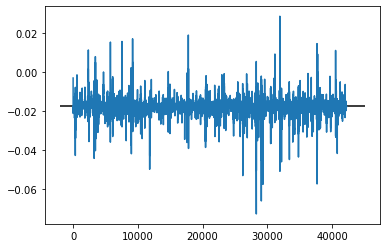

In [12]:
#taking the difference
diff54 = np.array([dist_54[i] - d for  i,d in enumerate(dist_5_4rel1) ])
plt.plot(diff54)
plt.hlines(diff54.mean(),-2000,45000)

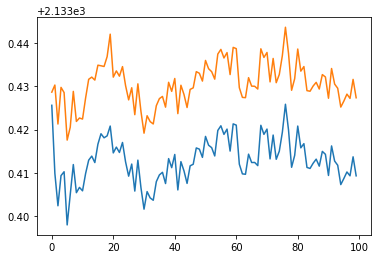

In [13]:
plt.plot(dist_54[:100])
plt.plot(dist_5_4rel1[:100])


so yes there is an offset, but its pretty constant.

### Do this for all baselines that dont have arc1

In [32]:
legs = ['arc5arc4',  'arc2arc5', 'arc5arc6',  'arc4arc6',]
rel2_1 = {}
diff = {}

p0 = Point(0,0)

for leg in legs:
    site1 = leg[4:]
    site2 = leg[:4]
    
    
    rel2_1[leg] =  [Point.distance(gdf[site1].geometry[i]) for i,Point in enumerate(gdf[site2].geometry)]
    
    geometry = [Point(xy) for xy in zip( ddf[leg].dEast, ddf[leg].dNorth)]
    gdf_leg = gpd.GeoDataFrame(geometry=geometry)
    dist_leg = [p0.distance(point) for i,point in enumerate(gdf_leg.geometry)]
    
    diff[leg] = np.array([dist_leg[i] - d for  i,d in enumerate(rel2_1[leg]) ])
    
    

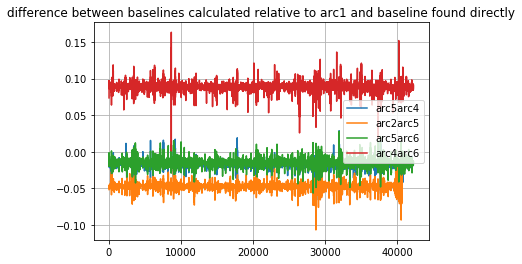

In [37]:
for d in diff:
    plt.plot(diff[d])
plt.legend(diff.keys())
plt.title("difference between baselines calculated relative to arc1 and baseline found directly")
plt.grid()

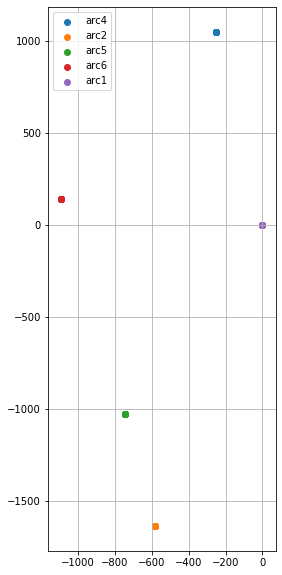

In [14]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
for df in gdf:
    gdf[df].plot(ax=ax)
    plt.grid()

plt.legend(gdf.keys())

## Convert relative points to real geopoints

### import arc1

In [16]:
siteunit = 'tal2arc1'
arc1_abs_gdf = gpd.read_file(f"/Volumes/arc_04/whitefar/DATA/TASMAN/GNSS_ABSOLUTE/GNSS_dataframe/{siteunit}_moreattributes.shp",header=0)

### check that it has the same times as our relative points

In [17]:
print(arc1_abs_gdf.Timestamp.size,gdf["arc2"]["Timestamp"].size)

42227 40661


### No it doesn't. Show the time period they cover:

In [18]:
start = datetime.datetime(2016, 5, 1).timestamp()
finish = datetime.datetime(2016, 5, 18).timestamp()
print("from   ",arc1_abs_gdf.Timestamp[0],gdf["arc2"].Timestamp[0],start)
print("till   ",arc1_abs_gdf.Timestamp[42226],gdf["arc2"].Timestamp[40660],finish)


from    1462017600.0 1462017600.0 1462017600.0
till    1463284800.0 1463245170.0 1463486400.0


In [19]:
# where do they start differing?
differentimeindex = np.argwhere(gdf["arc2"].Timestamp.to_numpy() - arc1_abs_gdf.Timestamp.to_numpy()[:40661] != 0).flatten()

In [20]:
# cut the rows which are at different times
arc1_origin = arc1_abs_gdf.iloc[:differentimeindex[0]]

rgdf = {} #reduced geodataframe
for name in gdf:
    rgdf[name] = gdf[name].iloc[:differentimeindex[0]]

In [21]:
### Now recheck the times
for name in gdf:
    differentimeindex = np.argwhere(rgdf[name].Timestamp.to_numpy() - arc1_origin.Timestamp.to_numpy() != 0).flatten()
    print(differentimeindex.shape)

(0,)
(0,)
(0,)
(0,)
(0,)


## We now have scynchronous dataframes

# Add the arc1 to each relative point to make them geopoints

In [22]:
out_gdfnames = list(gdf.keys())
out_gdfnames

['arc4', 'arc2', 'arc5', 'arc6', 'arc1']

In [24]:
out_gdfs = {}

out_gdfs['arc1'] = arc1_origin

for name in out_gdfnames:
    
    print(name)
        
    x, y = [rgdf[name].geometry.x + arc1_origin.geometry.x,rgdf[name].geometry.y + arc1_origin.geometry.y]
    geometry = [Point(xy) for xy in zip(x,y)]
    out_gdfs[name] = gpd.GeoDataFrame(geometry=geometry,crs={'init': 'epsg:2193'})
    out_gdfs[name]["Timestamp"] = rgdf[name].Timestamp
    
    

arc4
arc2
arc5
arc6
arc1


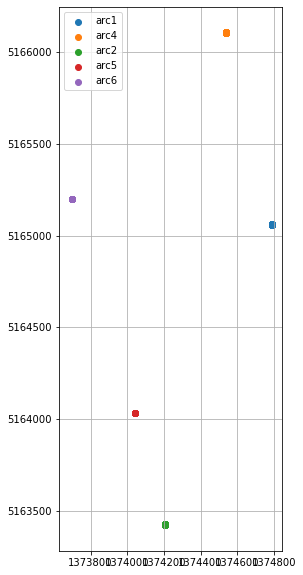

In [25]:
fig, ax = plt.subplots(1,1,figsize=[10,10])
for df in out_gdfs:
    out_gdfs[df].plot(ax=ax)
    plt.grid()

plt.legend(out_gdfs.keys())

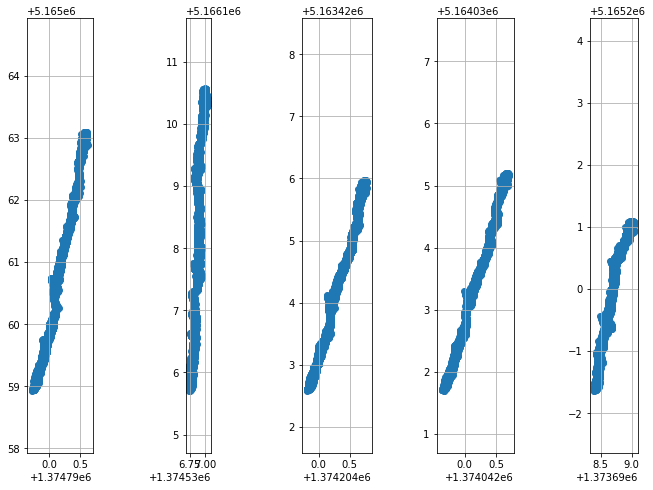

In [26]:
fig, axs = plt.subplots(1,5,figsize=[12,8],gridspec_kw = {'height_ratios':[1]})
axs = axs.ravel()
for i,df in enumerate(out_gdfs):
    
    ymin = out_gdfs[df].geometry.y.to_numpy().min()
    out_gdfs[df].plot(ax=axs[i]).set_ylim(ymin-1,ymin+6)
    axs[i].grid()


# Export the abs_from_rel_arc1 file

This means, absolute points, calculated as relative distances from the absolute arc1

In [27]:
for gdf in out_gdfs:
    out_gdfs[gdf].to_file(f"/Volumes/arc_04/whitefar/DATA/TASMAN/GNSS_relative/DATAFRAME/{gdf}_abs_from_rel_arc1.shp")